# Product Identification using Deep Learning

In [2]:
import os
from torchvision import datasets
import numpy as np
import cv2                
import matplotlib.pyplot as plt 
import torch
import torchvision.models as models
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import PIL
from imgaug import augmenters as iaa
import imgaug as ia

In [3]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

print(use_cuda)

True


In [3]:
### downloading images from google 

In [ ]:
# import required packages
import requests
import cv2
import os
 
from imutils import paths
 
url_path = open('download3').read().strip().split('\n')
total = 0
 
if not os.path.exists('images'):
    os.mkdir('images')
image_path = 'images'
 
for url in url_path:
    try:
        req = requests.get(url, timeout=60)
 
        file_path = os.path.sep.join([image_path, '{}.jpg'.format(
            str(total).zfill(6))]
        )
        file = open(file_path, 'wb')
        file.write(req.content)
        file.close()
 
        print('Downloaded {}'.format(file_path))
        total += 1
 
    except:
        print('Could not download {}. Downloading next file'.format(file_path))

In [ ]:
## removing images that cannot be opened

In [ ]:
for imagePath in paths.list_images('dataset/train/shirt'):
    delete_image = False
 
    try:
        image = cv2.imread(imagePath)
 
        if image is None:
            delete_image = True
 
    # if OpenCV cannot load the image
    except:
        delete_image = True
 
    if delete_image:
        print('Deleting {}'.format(imagePath))
        os.remove(imagePath)

In [6]:
import numpy as np
from glob import glob

In [ ]:
!unzip /content/dataset.zip -d /content/

In [7]:
saree_files = np.array(glob("dataset/train/saree/*"))
kurti_files = np.array(glob("dataset/train/kurti/*"))
shirt_files = np.array(glob("dataset/train/shirt/*"))
print(len(saree_files))
print(len(kurti_files))
print(len(shirt_files))


224
224
224


In [1]:
#test data creation (20% of train data)

In [ ]:
import os, shutil
from random import choice

rootdir = '/content/dataset/train/shirt'
output_dir = '/content/dataset/test/shirt'
for subdir, dir, files in os.walk(rootdir):
    if files:
        for x in range(int(len(files) *.20)):
            to_copy = choice(files)
            print(to_copy)
            path=os.path.join(subdir, to_copy)
            #print(path)
           
            shutil.copy(os.path.join(subdir, to_copy), os.path.join(output_dir, to_copy))
            try: 
                os.remove(path) 
            except OSError as error: 
                print(error) 
                print("File path can not be removed") 
            

In [ ]:
!zip -r /content/file.zip /content/dataset

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=8):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))for i in range(15)))
    plt.imshow(img)
    plt.axis('off')

In [5]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'
valid_dir = 'dataset/valid'

### Augmentation

In [6]:
class ImgAugTransform1:
    
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.aug = iaa.Sequential(
    [
        # to most images
        iaa.Fliplr(0.5), # horizontal flip 
        iaa.Flipud(0.2), # vertical flip 
        
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Invert(0.05, per_channel=True)), #invert!
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
            rotate=(-45, 45), 
            shear=(-16, 16),
            order=[0, 1], 
            cval=(0, 255),
            mode=ia.ALL 
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), 
                    iaa.AverageBlur(k=(2, 7)), 
                    iaa.MedianBlur(k=(3, 11)), 
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), 
         
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True),
                iaa.Add((-10, 10), per_channel=0.5), 
                iaa.AddToHueAndSaturation((-20, 20)),
          
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), 
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)



In [7]:
 ## to visualize the transformations  by imgaug
Xtransform=torchvision.transforms.Compose([
    ImgAugTransform1(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
  
    
])
train_data2=datasets.ImageFolder(train_dir , transform=Xtransform)


C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [10]:
# actual tranfomied and normalised image converted to tensor that would be passed to the model
Ftransforms = torchvision.transforms.Compose([
    ImgAugTransform1(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    
])

In [11]:
## Applying transformations on the train and test data
train_data = datasets.ImageFolder(train_dir , transform=Ftransforms)
test_data= datasets.ImageFolder(test_dir, transform=Ftransforms)

In [12]:
valid_data= datasets.ImageFolder(valid_dir, transform=Ftransforms)

C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':
C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\imgaug\augmenters\segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  image, n_segments=n_segments_samples[i], compactness=10)


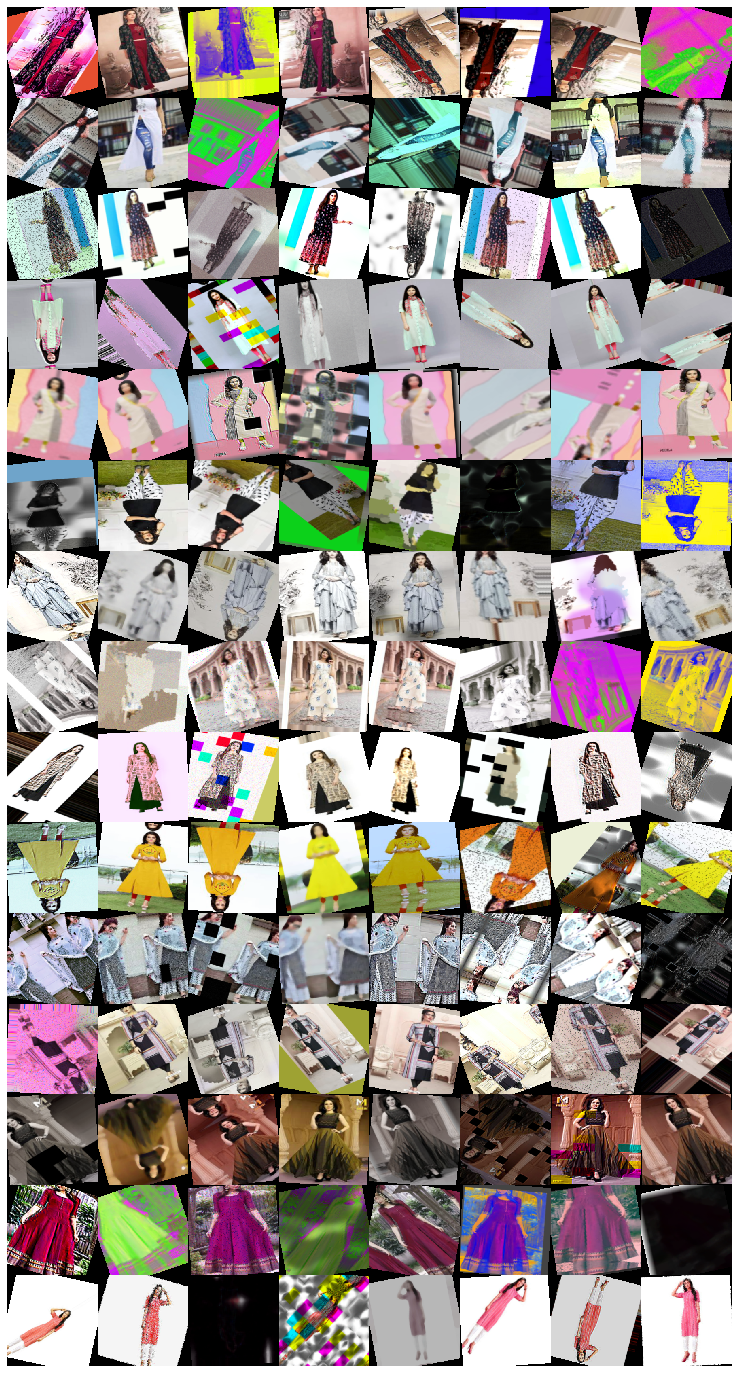

In [8]:
show_dataset(train_data2)

## Training

In [13]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [14]:
validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)

In [15]:
print(train_data.classes)

['kurti', 'saree', 'shirt']


In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
loaders_transfer = {
    'train': trainloader,
    'valid': validloader,
    'test': testloader
}


In [18]:
# Load the pretrained model from pytorch
res50 = models.resnet50(pretrained=True)

In [22]:
print(res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# transfer learning on ResNet

In [19]:
import torchvision.models as models
import torch.nn as nn
model_transfer=res50

for name,child in model_transfer.named_children():
    if name in ['fc','layer4']:
        print(name + 'is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + 'is frozen')
        for param in child.parameters():
            param.requires_grad = False

model_transfer.fc = nn.Sequential(
               nn.Linear(2048, 516),
               nn.ReLU(inplace=True),
               nn.Linear(516,64),
               nn.ReLU(inplace=True),
               nn.Linear(64,3))


if use_cuda:
    model_transfer = model_transfer.cuda()

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is frozen
layer3is frozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [20]:
model_transfer  # our model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [21]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer =  optim.SGD(filter(lambda p:p.requires_grad,model_transfer.parameters()), lr=0.002, momentum=0.9)
## need to pass only those param that are unfrrozen!!

In [27]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            
            loss = criterion(output, target)
             
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss,valid_loss))
        
       
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            print(" ")
            #torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
            state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(), 'losslogger': criterion, }
            torch.save(state,save_path)
            
    # return trained model
    return model



In [28]:
# train the model
n_epochs=100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')



Epoch: 1 	Training Loss: 1.097491 	Validation Loss: 1.098777
Validation loss decreased (inf --> 1.098777).  Saving model ...
 
Epoch: 2 	Training Loss: 1.094753 	Validation Loss: 1.093619
Validation loss decreased (1.098777 --> 1.093619).  Saving model ...
 
Epoch: 3 	Training Loss: 1.089299 	Validation Loss: 1.086537
Validation loss decreased (1.093619 --> 1.086537).  Saving model ...
 
Epoch: 4 	Training Loss: 1.081449 	Validation Loss: 1.081895
Validation loss decreased (1.086537 --> 1.081895).  Saving model ...
 
Epoch: 5 	Training Loss: 1.074128 	Validation Loss: 1.073486
Validation loss decreased (1.081895 --> 1.073486).  Saving model ...
 
Epoch: 6 	Training Loss: 1.062434 	Validation Loss: 1.059974
Validation loss decreased (1.073486 --> 1.059974).  Saving model ...
 
Epoch: 7 	Training Loss: 1.056332 	Validation Loss: 1.052636
Validation loss decreased (1.059974 --> 1.052636).  Saving model ...
 
Epoch: 8 	Training Loss: 1.037375 	Validation Loss: 1.042054
Validation loss decr

KeyboardInterrupt: ignored

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [22]:
checkpoint = torch.load('model_transfer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])
optimizer_transfer.load_state_dict(checkpoint['optimizer'])
n_epochs = checkpoint['epoch']
criterion_transfer = checkpoint['losslogger']

C:\Users\anush\Anaconda3\envs\nano\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Testing

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [31]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.393063


Test Accuracy: 83% (137/165)


## Final Pipeline

In [25]:
class_names= train_data.classes
print(len(class_names))
print("0",class_names[0])
print("1",class_names[1])
print("2",class_names[2])

3
0 kurti
1 saree
2 shirt


In [26]:
def predict_product(img_path):
    
    transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    file = img_path
    file = Image.open(file).convert('RGB')
    img = transform(file).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model_transfer.eval()
    
    with torch.no_grad():
        
        out = model_transfer(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        index = top_class.item()
    return class_names[index]

In [27]:
import matplotlib.pyplot as plt
import matplotlib
def display_product(file):
    file = Image.open(file).convert('RGB')
    plt.figure(figsize = (40,5))
    plt.imshow(file)
    matplotlib.pyplot.text(5, -20, "HEllO, Lets detect the product !",
    color='black', fontsize=15)
    plt.show()

In [28]:
def run_app(img_path):

        product_name = predict_product(img_path)
        display_product(img_path)
        print("Predicted product is :", product_name)


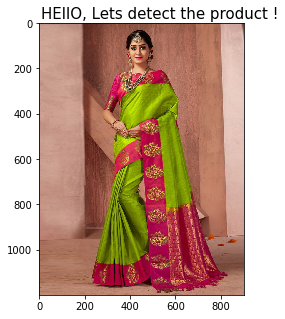

Predicted product is : saree


In [36]:
run_app('sar1.jpg')

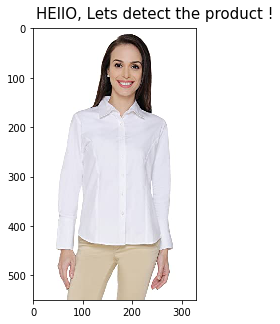

Predicted product is : shirt


In [37]:
run_app('test7.jpg') #got classified correctly in this model

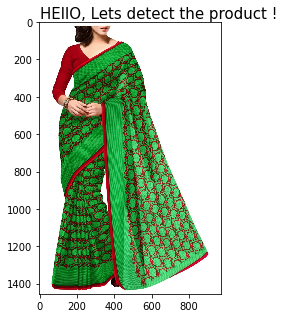

Predicted product is : saree


In [38]:
run_app('testx.jpg')

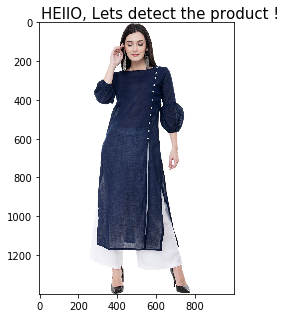

Predicted product is : kurti


In [29]:
run_app('testt.jpg')

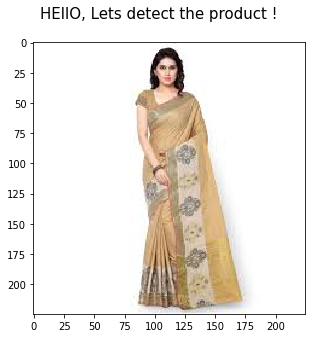

Predicted product is : saree


In [40]:
run_app('testz.jpeg')

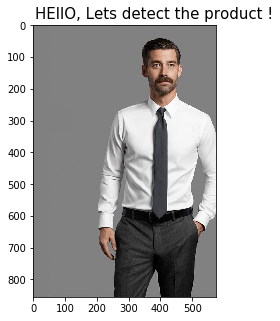

Predicted product is : shirt


In [ ]:
run_app('images/apptest/test6.jpg')

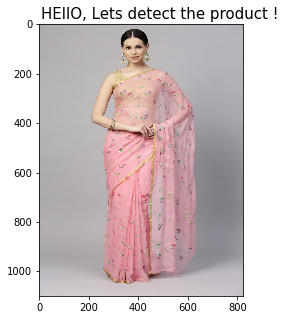

Predicted product is : saree


In [53]:
run_app('check1.jpeg')

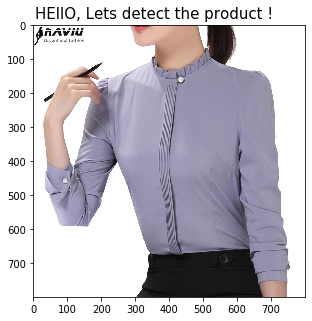

Predicted product is : shirt


In [ ]:
run_app('images/apptest/test9.jpg')

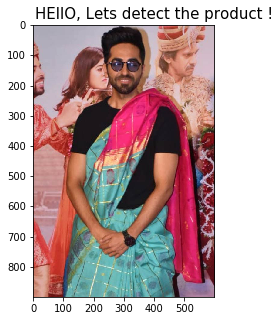

Predicted product is : saree


In [ ]:
run_app('images/apptest/test10.jpg')

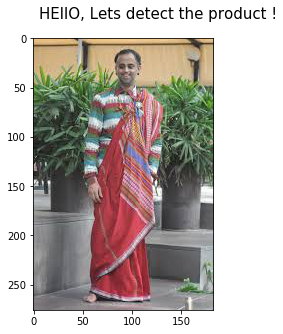

Predicted product is : saree


In [ ]:
run_app('images/apptest/test11.jpeg')

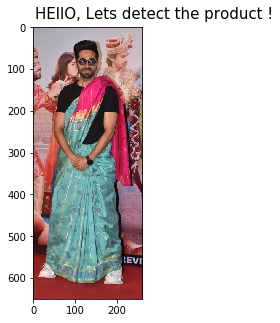

Predicted product is : saree


In [ ]:
run_app('images/apptest/test12.jpg')

In [41]:
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [42]:
def make_heatmap(image,true_image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = model_transfer(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        #print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (50, 50)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [54]:
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
file = 'check1.jpeg'
file1 = Image.open(file).convert('RGB')
myimg = transform(file1).unsqueeze(0)

In [55]:
#true_image=file

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


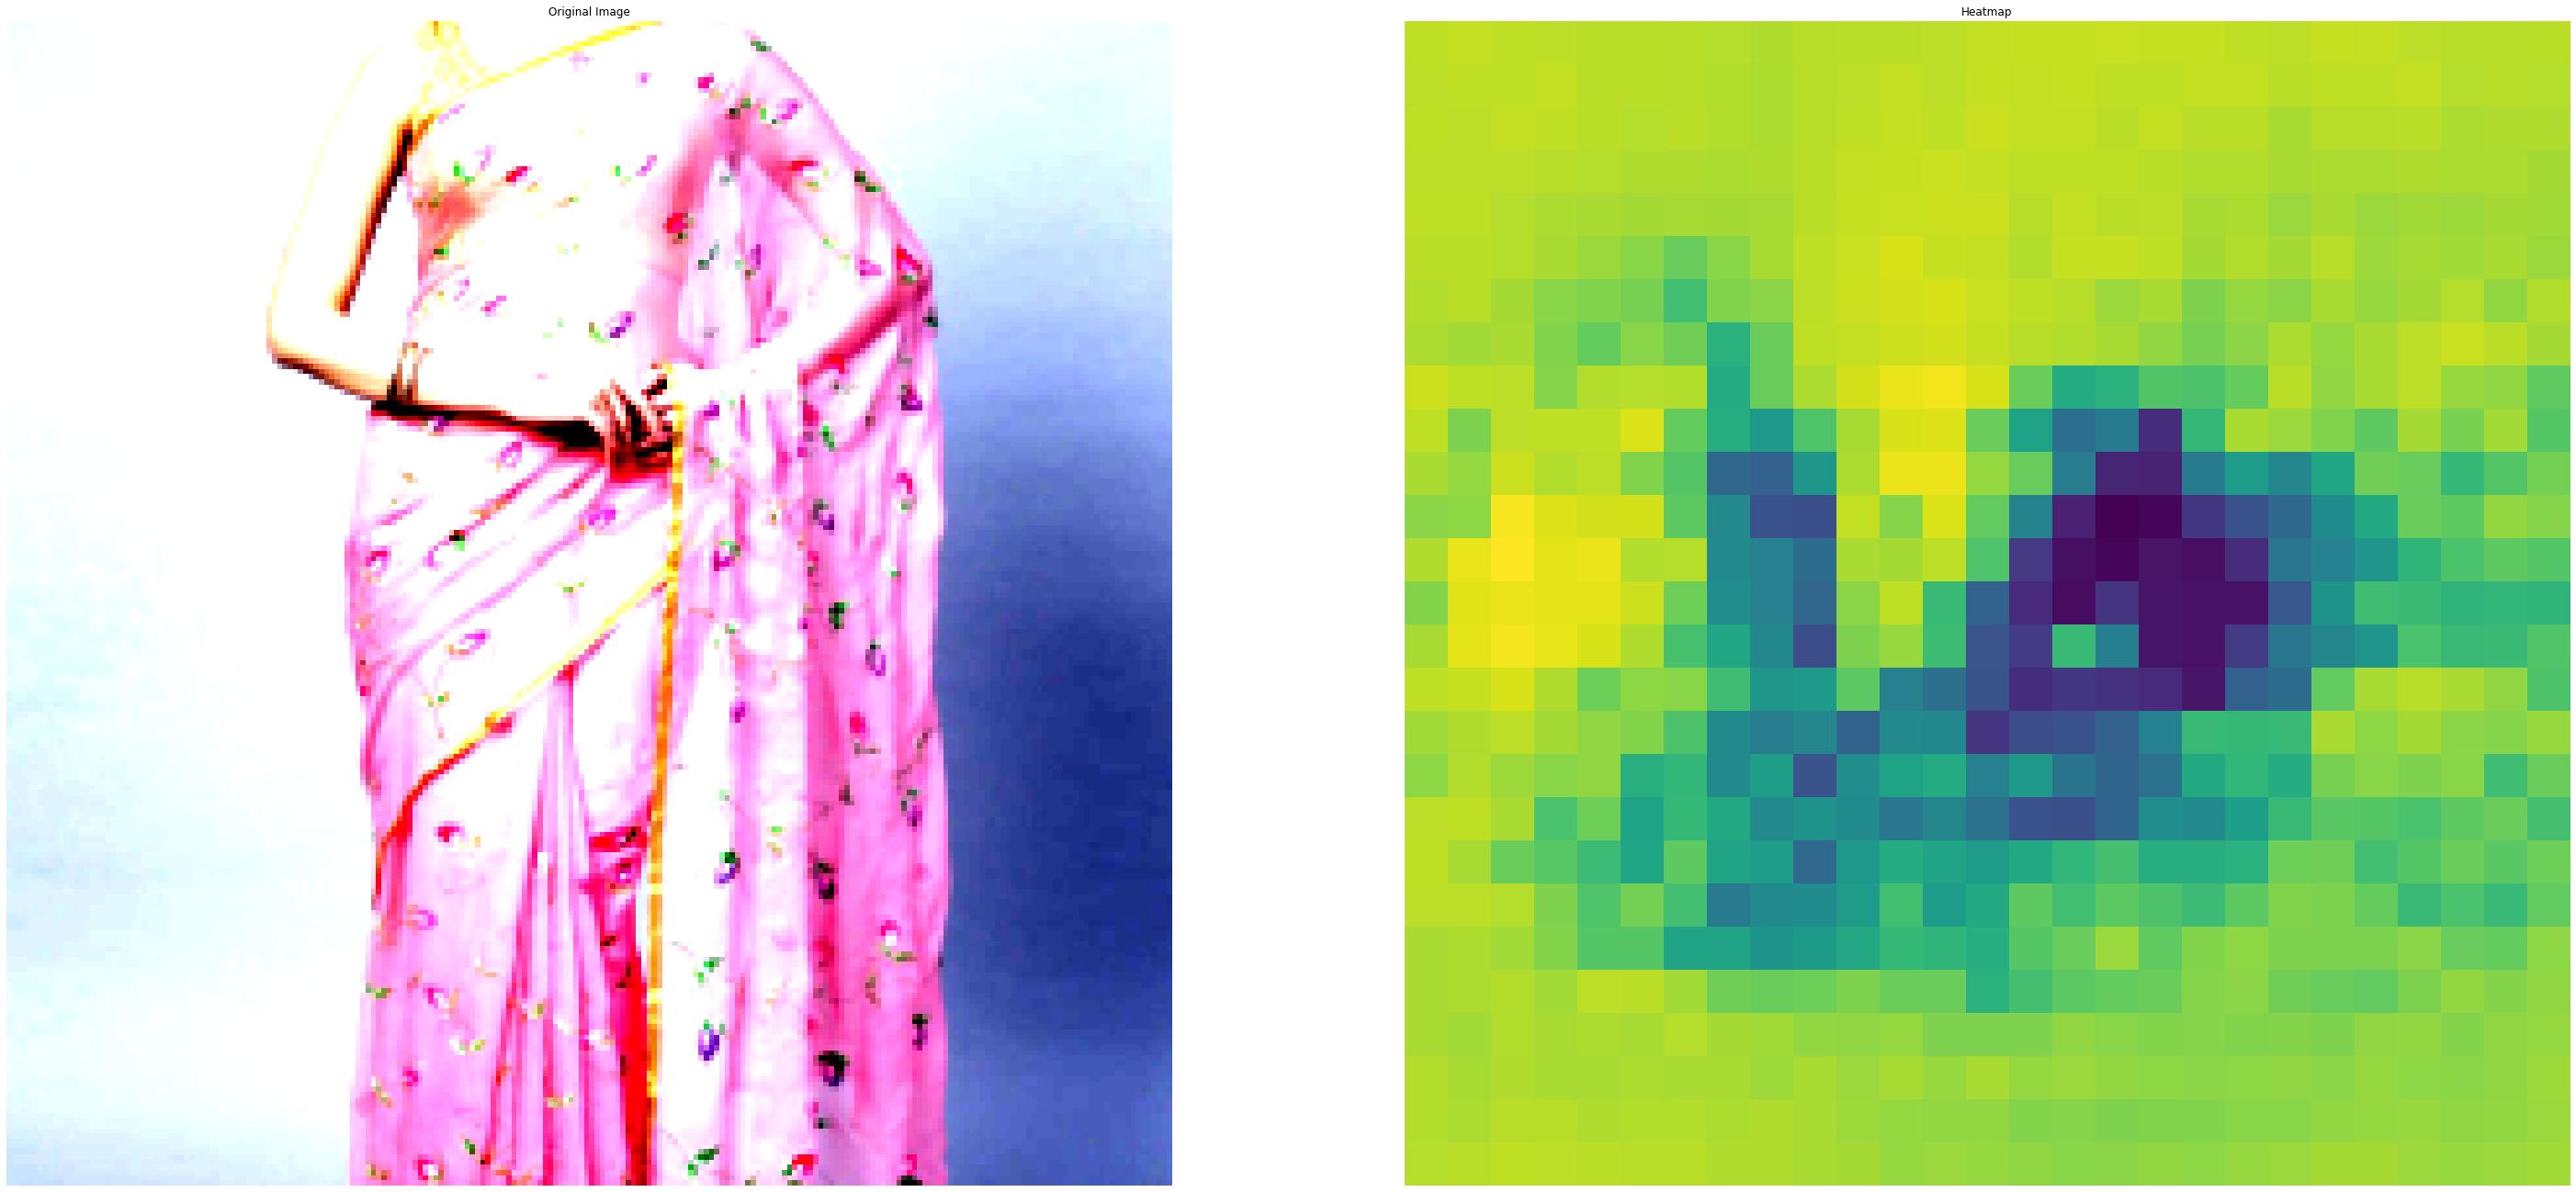

In [56]:
myheatmap = make_heatmap(myimg,file, 1, 16, 8)  # Extremely slow